In [215]:
import numpy as np
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import gene_sets


import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

In [216]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
DATA_FOLDER = "../../../data/"
adata = anndata.read_h5ad(f"{DATA_FOLDER}cellcycle_maxine/RPE_37C_Rep1_full.h5ad")
# adata = anndata.read_h5ad("../data/cellcycle_maxine/different_cell_types/phase_VASA.h5ad")
adata

AnnData object with n_obs × n_vars = 5865 × 36591
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [218]:
adata

AnnData object with n_obs × n_vars = 5865 × 36591
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [219]:
adata = anndata.concat(
    [adata, anndata.read_h5ad(f"{DATA_FOLDER}cellcycle_maxine/RPE_37C_Rep2_full.h5ad")]
)

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [220]:
adata.obs_names_make_unique()

In [221]:
adata.layers["spliced"] = adata.layers["spliced"].astype("uint16")
adata.layers["unspliced"] = adata.layers["unspliced"].astype("uint16")

In [222]:
adata = adata[:, ~adata.var_names.duplicated()].copy()

In [223]:
sc.pp.filter_genes(adata, min_cells=10)

In [224]:
# create a new layer copy of the spliced layer
adata.layers["s_norm"] = adata.layers["spliced"].copy()
adata.layers["u_norm"] = adata.layers["unspliced"].copy()

# normalize the spliced layer, adding layer option, indicates which layer we want to normalize
sc.pp.normalize_total(adata, target_sum=1e4, layer="s_norm")
sc.pp.normalize_total(adata, target_sum=1e4, layer="u_norm")

# copy the normalized layer to a new layer, s_log
adata.layers["s_log"] = adata.layers["s_norm"].copy()
adata.layers["u_log"] = adata.layers["u_norm"].copy()

# log transform the normalized layer
sc.pp.log1p(adata, layer="s_log")
sc.pp.log1p(adata, layer="u_log")
# add % unspliced to adata.obs
adata.obs["s_counts"] = adata.layers["spliced"].sum(axis=1)
adata.obs["u_counts"] = adata.layers["unspliced"].sum(axis=1)

adata.obs["percent_unspliced"] = adata.obs["u_counts"] / (
    adata.obs["u_counts"] + adata.obs["s_counts"]
)

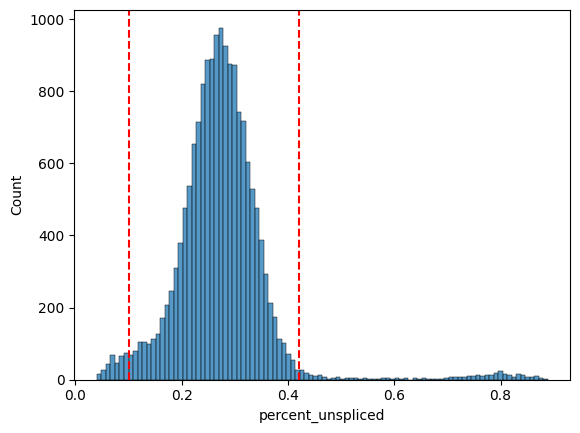

In [225]:
# plot distribution of % unspliced
sns.histplot(adata.obs["percent_unspliced"], bins=100)
# lower threshold for % unspliced
low_percent_unspliced = 0.1
# upper threshold for % unspliced
high_percent_unspliced = 0.42
plt.axvline(low_percent_unspliced, color="red", linestyle="--")
plt.axvline(high_percent_unspliced, color="red", linestyle="--")

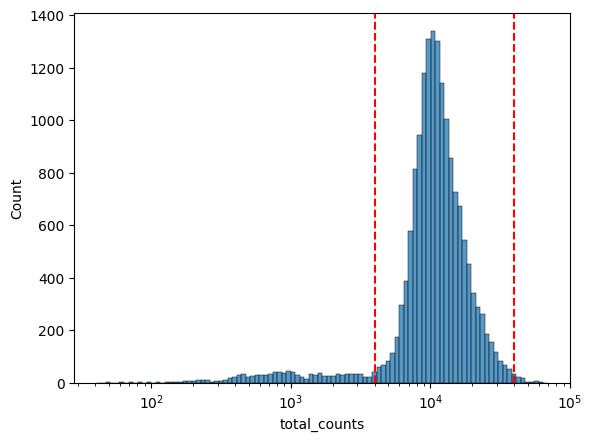

In [226]:
# add total counts to adata.obs
adata.obs["total_counts"] = adata.layers["spliced"].sum(
    axis=1
)  # + adata.layers["unspliced"].sum(axis=1)
# plot distribution of total counts
sns.histplot(adata.obs["total_counts"], bins=100, log_scale=True)
# lower threshold for total counts
low_total_counts = 4000
# upper threshold for total counts
high_total_counts = 40000
plt.axvline(low_total_counts, color="red", linestyle="--")
plt.axvline(high_total_counts, color="red", linestyle="--")

In [227]:
# filter cells based on thresholds
adata = adata[
    (adata.obs["percent_unspliced"] > low_percent_unspliced)
    & (adata.obs["percent_unspliced"] < high_percent_unspliced)
    & (adata.obs["total_counts"] > low_total_counts)
    & (adata.obs["total_counts"] < high_total_counts)
].copy()

In [228]:
adata.obs

,batch,s_counts,u_counts,percent_unspliced,total_counts
CellID,,,,,
AAACCCACAAATTGGAx,RPE_37C_Rep1,9133,2155,0.190911,9133
AAACCCACAAGTAGTAx,RPE_37C_Rep1,8404,2950,0.259820,8404
AAACCCAGTCTGTGGCx,RPE_37C_Rep1,8828,3323,0.273475,8828
AAACGAACATCCAACAx,RPE_37C_Rep1,13362,1887,0.123746,13362
AAACGAATCGTCTCACx,RPE_37C_Rep1,4594,2089,0.312584,4594
...,...,...,...,...,...
TTTGGTTTCGTGGTATx,RPE_37C_Rep2,12450,5077,0.289667,12450
TTTGGTTTCTAACACGx,RPE_37C_Rep2,9981,4365,0.304266,9981
TTTGGTTTCTTTGATCx,RPE_37C_Rep2,5195,2196,0.297118,5195


In [229]:
adata_all_genes = adata.copy()
layer_to_use = "spliced"
library_size = adata_all_genes.layers[layer_to_use].sum(axis=1).A1

In [230]:
adata.X = adata.layers["spliced"].copy()  # + adata.layers["unspliced"]

In [231]:
# Preprocess data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [232]:
SMALL_CYCLING_GENE_SET = gene_sets.SMALL_CELL_CYCLE_GENE_SET
SMALL_CYCLING_GENE_SET = [x.upper() for x in SMALL_CYCLING_GENE_SET]
adata = adata[:, adata.var_names.isin(SMALL_CYCLING_GENE_SET)]

In [233]:
len(SMALL_CYCLING_GENE_SET)

98

In [234]:
# mean center the adata
adata.X = adata.X - adata.X.mean(axis=1)

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


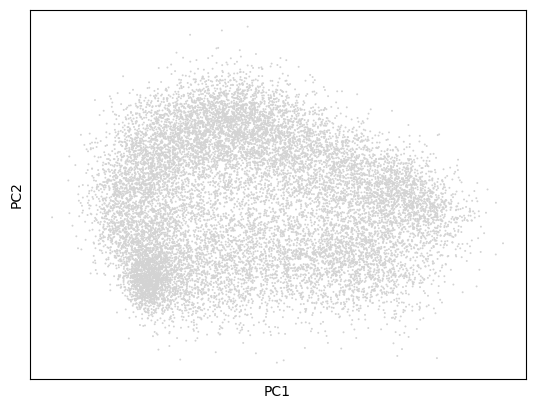

In [235]:
# pca on the data
sc.pp.pca(adata)
# plot the pca
sc.pl.pca(adata)

In [236]:
# add PCA theta to adata.obs
adata.obs["pca_theta"] = np.arctan2(
    adata.obsm["X_pca"][:, 1], adata.obsm["X_pca"][:, 0]
)
adata_all_genes.obs["pca_theta"] = adata.obs["pca_theta"].copy()
adata = adata_all_genes.copy()

<Axes: ylabel='Frequency'>

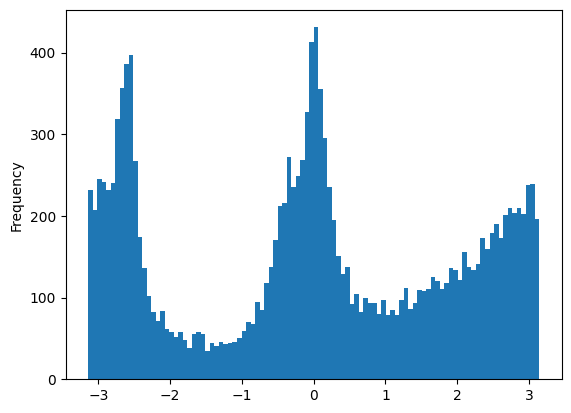

In [237]:
adata.obs["pca_theta"].plot.hist(bins=100)

In [238]:
g = utils.get_variable_genes(adata)
len(g)

2000

In [239]:
pd.DataFrame(g).to_csv("var_genes.csv")

In [240]:
adata.obs

,batch,s_counts,u_counts,percent_unspliced,total_counts,pca_theta
CellID,,,,,,
AAACCCACAAATTGGAx,RPE_37C_Rep1,9133,2155,0.190911,9133,-2.591439
AAACCCACAAGTAGTAx,RPE_37C_Rep1,8404,2950,0.259820,8404,-3.031984
AAACCCAGTCTGTGGCx,RPE_37C_Rep1,8828,3323,0.273475,8828,-1.862426
AAACGAACATCCAACAx,RPE_37C_Rep1,13362,1887,0.123746,13362,-2.828957
AAACGAATCGTCTCACx,RPE_37C_Rep1,4594,2089,0.312584,4594,-2.282639
...,...,...,...,...,...,...
TTTGGTTTCGTGGTATx,RPE_37C_Rep2,12450,5077,0.289667,12450,-2.923702
TTTGGTTTCTAACACGx,RPE_37C_Rep2,9981,4365,0.304266,9981,2.829323
TTTGGTTTCTTTGATCx,RPE_37C_Rep2,5195,2196,0.297118,5195,-2.326212


Epoch 1/200, elbo_loss: 2677.1847, kl_div_f: 4.6776, kl_div_z: 23.3802, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.5779, entropy_loss: -515.5766, radial_variance: 3.5314, radius: 7.3042, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 2172.4437
Epoch 2/200, elbo_loss: 1223.3245, kl_div_f: 4.6209, kl_div_z: 8.2307, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.9050, entropy_loss: -581.0037, radial_variance: 10.4352, radius: 20.0436, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 672.8019
Epoch 3/200, elbo_loss: 1176.2421, kl_div_f: 4.5644, kl_div_z: 8.2144, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.9323, entropy_loss: -586.4636, radial_variance: 7.7038, radius: 10.5516, L1_mu_z: 0.0000, MI_loss: -0.0001, total_loss: 608.0176
Epoch 4/200, elbo_loss: 1151.9084, kl_div_f: 4.5028, kl_div_z: 8.2140, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.9248, ent

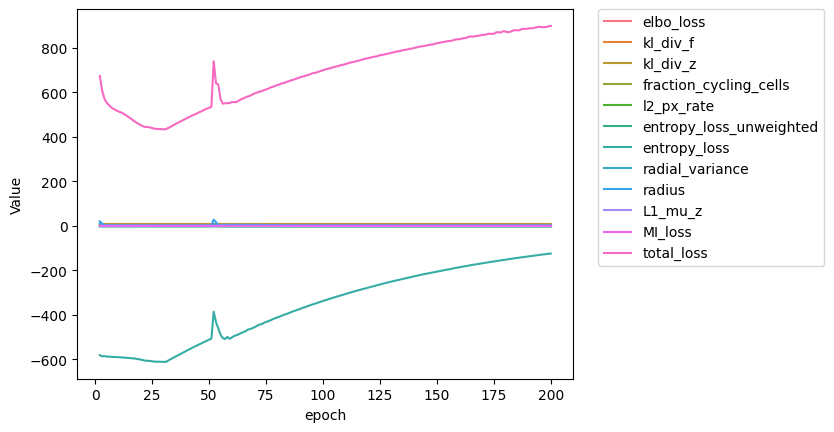

In [241]:
model = CoPhaser(
    ["TOP2A", "PCNA"],
    g,
    n_latent=2,
)
model.load_anndata(adata, layer_to_use="spliced")
trainer = Trainer(
    model,
    Loss.compute_loss,
    noise_model="NB",
    non_rhythmic_likelihood_weight=1,
    rhythmic_likelihood_weight=10,
    L2_Z_decoder_loss_weight=0,
    closed_circle_weight=10,
    cycling_status_prior=1,
    MI_weight=200,
    entropy_weight_factor=200,
    MI_detach="f",
)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=2048,
    ,
)

<Axes: ylabel='Count'>

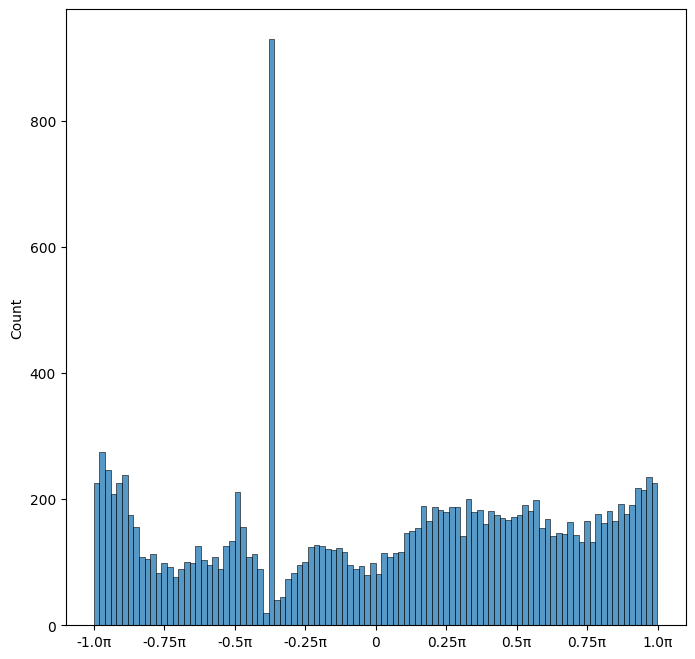

In [242]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"]
plotting.modify_axis_labels()
sns.histplot(thetas, bins=100)

<Axes: xlabel='pca_theta', ylabel='None'>

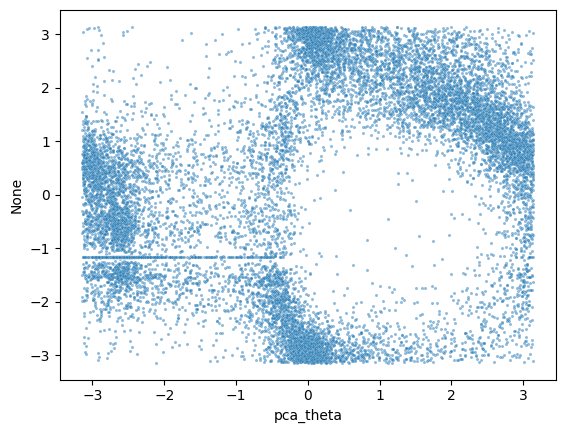

In [243]:
sns.scatterplot(x=adata.obs["pca_theta"], y=thetas, alpha=0.5, s=5)

In [244]:
df_f = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
df_f["inferred_theta"] = thetas
res = utils.get_ptp_phase(df_f, columns_not_gene=["inferred_theta"])

In [245]:
adata[:, model.context_genes].layers["spliced"]

<Compressed Sparse Row sparse matrix of dtype 'uint16'
	with 5210976 stored elements and shape (15237, 2000)>

In [246]:
adata[:, model.context_genes].layers["spliced"] / adata.layers["spliced"].sum(
    axis=1
)

<COOrdinate sparse matrix of dtype 'float64'
	with 5210976 stored elements and shape (15237, 2000)>

In [247]:
res.loc[model.context_genes, "mean_expression"] = (
    np.log1p(
        (
            adata[:, model.context_genes].layers["spliced"]
            / adata.layers["spliced"].sum(axis=1)
        )
        * 10**4
    )
    .mean(axis=0)
    .A1
)
res["score"] = np.exp(res["peak_to_peak"]) * res["mean_expression"]

In [248]:
res.sort_values(by="score", ascending=False).head(20)

,peak_to_peak,phase,mean_expression,score
TOP2A,3.895221,-2.862356,1.580112,77.689243
PCNA,4.062766,1.281487,0.969222,56.345617
HIST1H4C,2.866262,2.059938,2.765322,48.590069
CDK1,3.803730,-3.129519,0.584097,26.207374
UBE2C,3.384127,3.050263,0.753766,22.230237
GAPDH,1.480397,0.431421,4.663995,20.496814
MKI67,2.529725,-2.862356,1.574476,19.759751
CENPF,2.243151,-2.862356,1.821584,17.164741
HMGB2,2.362718,-2.862356,1.546140,16.419664
HIST1H1B,3.672510,1.902455,0.405171,15.943683


In [249]:
two_genes_res = {"phases": thetas, "gene_score": res, "df_rhythmic": df_f}

Epoch 1/200, elbo_loss: 3080.6329, kl_div_f: 4.6777, kl_div_z: 25.4048, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.0525, entropy_loss: -410.5069, radial_variance: 8.1968, radius: 32.4985, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 2710.8213
Epoch 2/200, elbo_loss: 1671.8091, kl_div_f: 4.6206, kl_div_z: 7.8494, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.8235, entropy_loss: -564.6953, radial_variance: 7.2144, radius: 11.6558, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 1125.9846
Epoch 3/200, elbo_loss: 1622.1258, kl_div_f: 4.5665, kl_div_z: 8.2213, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.2189, entropy_loss: -643.7717, radial_variance: 3.9382, radius: 7.4482, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 989.7498
Epoch 4/200, elbo_loss: 1583.3522, kl_div_f: 4.5020, kl_div_z: 8.2202, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.2951, entr

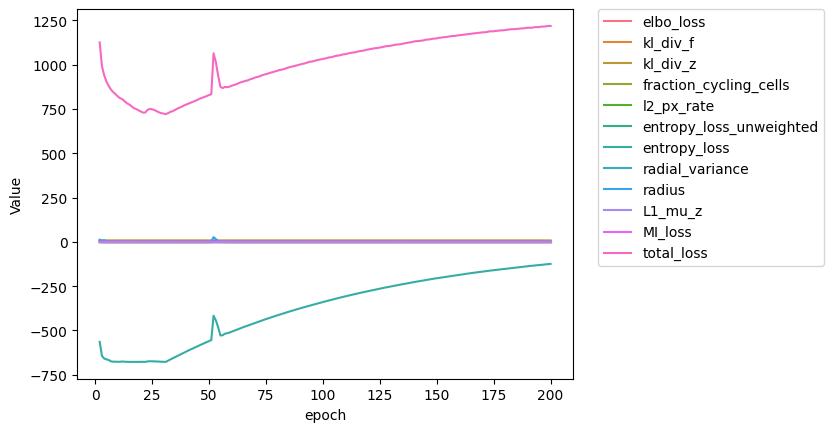

In [250]:
model = CoPhaser(
    res.sort_values(by="score", ascending=False).head(20).index.tolist(),
    g,
    n_latent=2,
)
model.load_anndata(adata, layer_to_use="spliced")
trainer = Trainer(
    model,
    Loss.compute_loss,
    noise_model="NB",
    non_rhythmic_likelihood_weight=1,
    rhythmic_likelihood_weight=10,
    L2_Z_decoder_loss_weight=0,
    closed_circle_weight=10,
    cycling_status_prior=1,
    MI_weight=200,
    entropy_weight_factor=200,
    MI_detach="f",
)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=2048,
    ,
)

<Axes: ylabel='Count'>

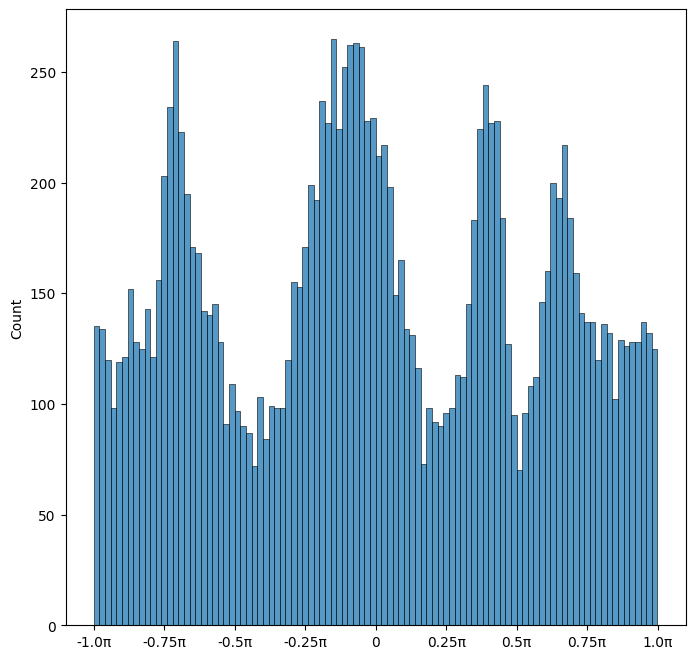

In [251]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"]
plotting.modify_axis_labels()
sns.histplot(thetas, bins=100)

<Axes: xlabel='pca_theta', ylabel='None'>

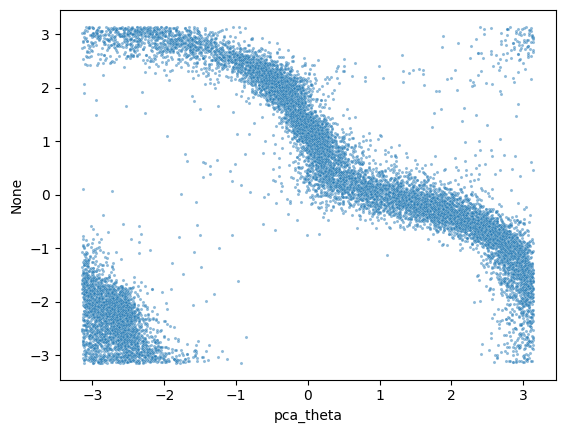

In [252]:
sns.scatterplot(x=adata.obs["pca_theta"], y=thetas, alpha=0.5, s=5)

In [253]:
df_f = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
df_f["inferred_theta"] = thetas
res = utils.get_ptp_phase(df_f, columns_not_gene=["inferred_theta"])

In [254]:
res.loc[model.context_genes, "mean_expression"] = (
    np.log1p(
        (
            adata[:, model.context_genes].layers["spliced"]
            / adata.layers["spliced"].sum(axis=1)
        )
        * 10**4
    )
    .mean(axis=0)
    .A1
)
res["score"] = np.exp(res["peak_to_peak"]) * res["mean_expression"]

In [255]:
twenty_genes_res = {"phases": thetas, "gene_score": res, "df_rhythmic": df_f}

In [ ]:
# to_save = {
#     "two_genes_res": two_genes_res,
#     "twenty_genes_res": twenty_genes_res,
# }
# import pickle

# with open("data/res_low_genes.pkl", "wb") as f:
#     pickle.dump(to_save, f)

: 